# Ozone Problem

In [1]:
# imports
import numpy as np
from scipy.ndimage import uniform_filter1d
from scipy.stats import shapiro
from matplotlib import pyplot as plt
import pandas

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import statsmodels.formula.api as smf

# Load dataset

## Downloaded CSV from here https://r-data.pmagunia.com/dataset/r-dataset-package-datasets-airquality

In [46]:
data = pandas.read_csv('../Data/Rdataset_airquality.csv')
data.head()

,Ozone,Solar.R,Wind,Temp,Month,Day
0,41.0,190.0,7.4,67,5,1
1,36.0,118.0,8.0,72,5,2
2,12.0,149.0,12.6,74,5,3
3,18.0,313.0,11.5,62,5,4
4,NaN,NaN,14.3,56,5,5


## NaNs?

In [52]:
goods = []
for key in data.keys():
    good = np.isfinite(data[key].values)
    goods.append(good)
#
all_good = np.all(goods, axis=0)

In [53]:
all_good.shape

(153,)

In [54]:
data = data[all_good].copy()
data.head()

,Ozone,Solar.R,Wind,Temp,Month,Day
0,41.0,190.0,7.4,67,5,1
1,36.0,118.0,8.0,72,5,2
2,12.0,149.0,12.6,74,5,3
3,18.0,313.0,11.5,62,5,4
6,23.0,299.0,8.6,65,5,7


## Time

In [55]:
year = 2015
dates = []
for index, row in data.iterrows():
    dates.append(f'{int(year)}-{int(row.Month)}-{int(row.Day)}')
dates = pandas.to_datetime(dates)
data['date'] = dates
data.set_index('date', inplace=True)
data.head()

,Ozone,Solar.R,Wind,Temp,Month,Day
date,,,,,,
2015-05-01,41.0,190.0,7.4,67,5,1
2015-05-02,36.0,118.0,8.0,72,5,2
2015-05-03,12.0,149.0,12.6,74,5,3
2015-05-04,18.0,313.0,11.5,62,5,4
2015-05-07,23.0,299.0,8.6,65,5,7


## Rename for convenience

In [56]:
data.rename(columns={'Solar.R': 'Rad'}, inplace=True)
data.head()

,Ozone,Rad,Wind,Temp,Month,Day
date,,,,,,
2015-05-01,41.0,190.0,7.4,67,5,1
2015-05-02,36.0,118.0,8.0,72,5,2
2015-05-03,12.0,149.0,12.6,74,5,3
2015-05-04,18.0,313.0,11.5,62,5,4
2015-05-07,23.0,299.0,8.6,65,5,7


# Simple functions

In [57]:
def square_it(x):
    return x**2

In [58]:
def log_it(x):
    return np.log10(x)

# Build a comprehensive model

In [36]:
formula = "Ozone ~ Wind + Rad + Temp + square_it(Wind) + Wind*Temp*Rad -1"  # -1 removes the Intercept
mod1 = smf.glm(formula=formula, data=data).fit()#, family=sm.families.Binomial()).fit()

In [37]:
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Ozone   No. Observations:                  111
Model:                            GLM   Df Residuals:                      103
Model Family:                Gaussian   Df Model:                            7
Link Function:               identity   Scale:                          335.28
Method:                          IRLS   Log-Likelihood:                -476.08
Date:                Wed, 20 Apr 2022   Deviance:                       34534.
Time:                        09:40:22   Pearson chi2:                 3.45e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9044
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Wind               -8.0331      3.504     -2.293      0.022     -14.900      -1.166
Rad                -0.1330      0.377     -0.353      0.724      -0.871       0.605
Temp                1.0515      0.284      3.705      0.000       0.495       1.608
square_it(Wind)     0.4057      0.124      3.275      0.001       0.163       0.648
Wind:Temp          -0.0310      0.049     -0.627      0.531      -0.128       0.066
Wind:Rad           -0.0110      0.037     -0.299      0.765      -0.083       0.061
Temp:Rad            0.0041      0.005      0.842      0.400      -0.005       0.014
Wind:Temp:Rad    2.167e-05      0.000      0.044      0.965      -0.001       0.001
===================================================================================
"""

# Best model

In [59]:
formula = "log_it(Ozone) ~ Wind + Rad + Temp + square_it(Wind)"  # -1 removes the Intercept
best_model = smf.glm(formula=formula, data=data).fit()#, family=sm.families.Binomial()).fit()

In [60]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          log_it(Ozone)   No. Observations:                  111
Model:                            GLM   Df Residuals:                      106
Model Family:                Gaussian   Df Model:                            4
Link Function:               identity   Scale:                        0.045979
Method:                          IRLS   Log-Likelihood:                 15.972
Date:                Wed, 20 Apr 2022   Deviance:                       4.8738
Time:                        09:51:53   Pearson chi2:                     4.87
No. Iterations:                     3   Pseudo R-squ. (CS):             0.8768
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.3142      0.281      1.119      0.263      -0.236       0.864
Wind               -0.0957      0.026     -3.681      0.000      -0.147      -0.045
Rad                 0.0011      0.000      4.682      0.000       0.001       0.002
Temp                0.0202      0.003      7.745      0.000       0.015       0.025
square_it(Wind)     0.0031      0.001      2.743      0.006       0.001       0.005
===================================================================================
"""

In [61]:
best_model.aic

-21.943294436384686

In [62]:
best_model.params

Intercept          0.314217
Wind              -0.095729
Rad                0.001099
Temp               0.020161
square_it(Wind)    0.003137
dtype: float64

## Plot

In [63]:
len(data), len(best_model.fittedvalues)

(111, 111)

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

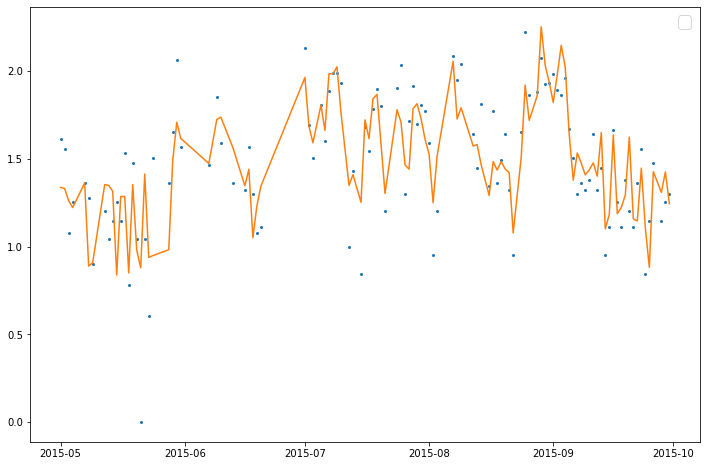

In [65]:
plt.clf()
fig = plt.figure(figsize=(12,8))
#
ax = plt.gca()
ax.plot(data.index, log_it(data.Ozone), 'o', ms=2)
# Fit
ax.plot(data.index, best_model.fittedvalues)#, label=f'p-value({entry}) = {mod1.pvalues.Intercept}')
#
#set_fontsize(ax, 17)
ax.legend(fontsize=17)
#
plt.show()